In [41]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib notebook

import matplotlib.units as munits
import matplotlib.dates as mdates
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter


In [42]:
my_data = np.genfromtxt('COVID19.csv', delimiter=',', converters={0: lambda x: np.datetime64(x)})

date = np.array([d[0] for d in my_data[1:]])
cases = np.array([d[1] for d in my_data[1:]])
deaths = np.array([d[2] for d in my_data[1:]])
casesVI = np.array([d[3] for d in my_data[1:]])

hosp = np.array([d[6] for d in my_data[1:]])

icu = np.array([d[7] for d in my_data[1:]])
print(cases)
print(my_data[1:][-1][7])

tests = np.array([d[4] for d in my_data[1:]])
yday = (date-np.datetime64('2020-01-01')).astype('float')
print(cases)

[  6.   7.   8.  11.  12.  18.  27.  53.  64.  73. 103. 186. 231. 271.
 348. 424. 472. 617. 659. 725.]
nan
[  6.   7.   8.  11.  12.  18.  27.  53.  64.  73. 103. 186. 231. 271.
 348. 424. 472. 617. 659. 725.]


In [43]:
def fitgrowth(t, cases, ntofit=None):
    good = np.isfinite(t+cases)
    t = t[good]
    cases=cases[good]
    
    if ntofit is None:
        ntofit = y
    tofit = np.where(t>t[-1]-ntofit)[0]
    print(tofit)
    t0 = t[tofit[0]]
    p, cov = np.polyfit(t[tofit]-t0, np.log(cases[tofit]), 1, cov=True)
    print(cov)
    tauhi = 1/(p[0]+np.sqrt(cov[0, 0]))
    print(tauhi)
    taulo = 1 / (p[0]-np.sqrt(cov[0, 0]))
    print(1/(p[0]-np.sqrt(cov[0, 0])))

    tau = 1/p[0]
    
    cases0 = np.exp(p[1])
    doubletime = np.log(2) * tau
    return tau, cases0, doubletime, t0, taulo, tauhi

<IPython.core.display.Javascript object>


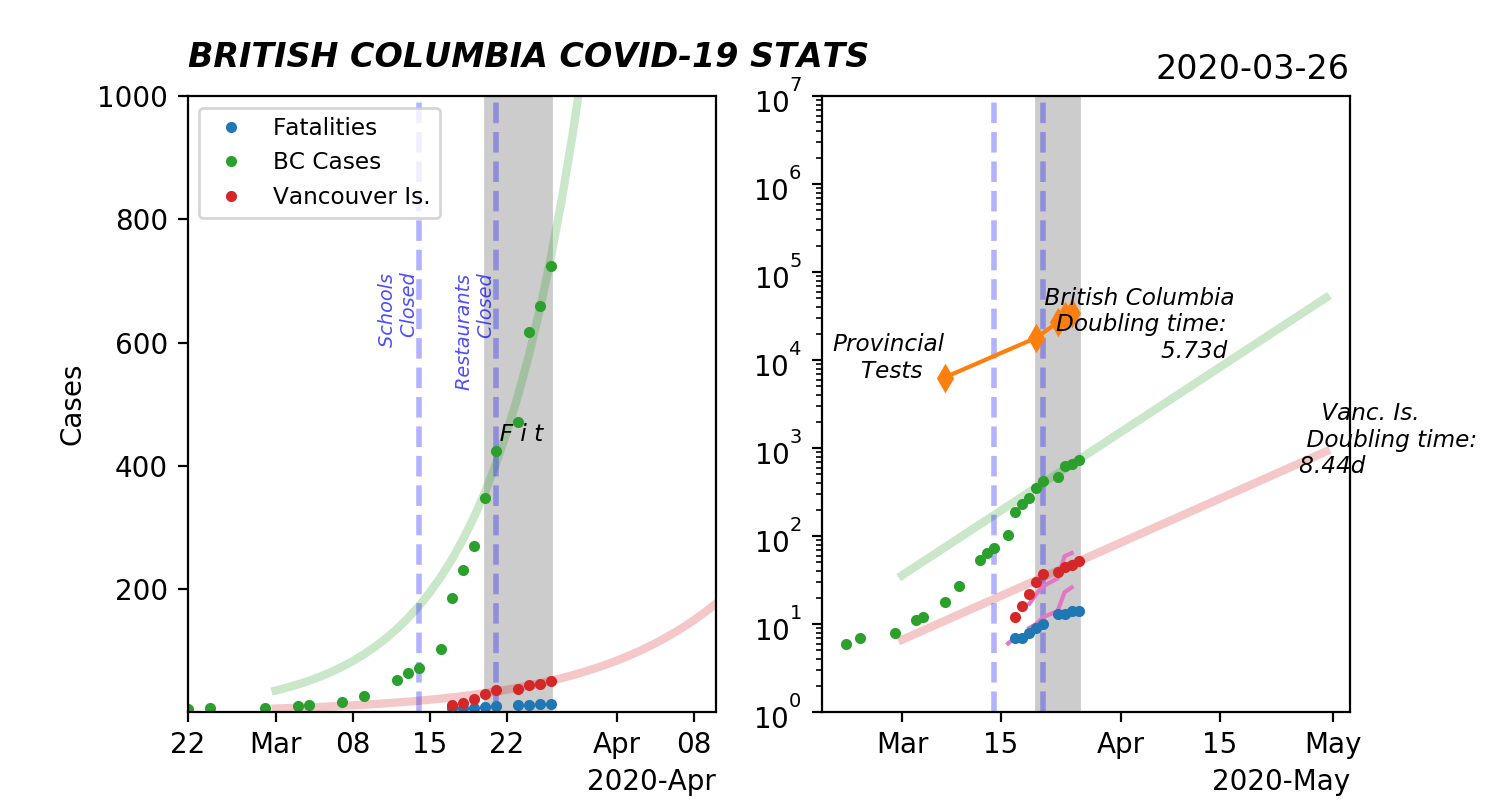

[14 15 16 17 18 19]
[[ 0.00013623 -0.0004314 ]
 [-0.0004314   0.00197535]]
7.533565161341687
9.141131908362686
[3 4 5 6 7 8]
[[ 9.20576099e-05 -2.91515765e-04]
 [-2.91515765e-04  1.33483534e-03]]
10.907702838047717
13.795196436870404
[14 15 16 17 18 19]
[[ 0.00013623 -0.0004314 ]
 [-0.0004314   0.00197535]]
7.533565161341687
9.141131908362686
[3 4 5 6 7 8]
[[ 9.20576099e-05 -2.91515765e-04]
 [-2.91515765e-04  1.33483534e-03]]
10.907702838047717
13.795196436870404


/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


In [44]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 4), constrained_layout=True)

for nn in range(2):
    ax = axs[nn]
    
    ax.semilogy(date, deaths, '.', label='Fatalities')

    good = np.where(np.isfinite(tests))[0]
    ax.semilogy(date[good], tests[good], 'd-')
    ax.text(date[good[0]], tests[good[0]], 'Provincial\nTests   ', fontsize='small', fontstyle='italic', ha='right')

    ax.semilogy(date, cases, '.', label='BC Cases', color='C2')
    ax.set_ylim(1, 400)

    tau, cases0, doubletime, t0, taulo, tauhi = fitgrowth(yday, cases, ntofit=7)
    
    dd = np.arange('2020-03', '2020-05', dtype='datetime64[D]')
    ddy = (dd-np.datetime64('2020-01-01')).astype('float')
    possiblecases = cases0*np.exp((ddy-t0)/tau)
    possiblecases = np.clip(possiblecases, 0, 5e6)
    
    ax.plot(dd, possiblecases, zorder=0, linewidth=3, alpha=0.25, color='C2')

    ind = np.where(possiblecases>1e4)[0][0]
    ax.text(dd[ind], possiblecases[ind], f' British Columbia\nDoubling time: \n{np.log(2) * tau:1.2f}d ', 
            ha='right', fontsize='small', fontstyle='italic')

    # VI
    ax.semilogy(date, casesVI, '.', label='Vancouver Is.', color='C3')

    tauVI, cases0VI, doubletimeVI, t0, taulo, tauhi = fitgrowth(yday, casesVI, ntofit=7)
    fitcases = cases0VI*np.exp((ddy-t0)/tauVI)
    fitcases = np.clip(fitcases, 0, 870297)
    ax.plot(dd, fitcases, zorder=0, linewidth=3, alpha=0.25, color='C3')

    ind = np.where(fitcases>0.5e3)[0][0]
    if nn==1:
        ax.text(dd[ind], fitcases[ind], f'      Vanc. Is.\n    Doubling time: \n   {np.log(2) * tauVI:1.2f}d ', 
            ha='left', fontsize='small', fontstyle='italic')


    if nn == 0:
        ax.set_ylim(1, 1000)
        ax.set_yscale('linear')    
        ax.legend(loc=2, fontsize='small')
    else:
        ax.set_yscale('log')
        ax.set_ylim(1, 1e7)
    ax.axvline(np.datetime64('2020-03-14'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)
    ax.axvline(np.datetime64('2020-03-21'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)

    if nn==0:
        axs[0].text(np.datetime64('2020-03-14'),600, 'Schools \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right', fontstyle='italic')
        axs[0].text(np.datetime64('2020-03-21'),530, 'Restaurants \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right',fontstyle='italic')


    ax.axvspan(date[-1]-np.timedelta64(6, 'D'), date[-1], color='0.8', zorder=-1)
axs[0].text(date[-1]-np.timedelta64(6, 'D'), 440, '  F i t', rotation=0, fontsize='small', fontstyle='italic')
axs[0].set_ylabel('Cases')
axs[0].set_title(f'BRITISH COLUMBIA COVID-19 STATS ', loc='left', y=1.02, fontweight='bold', fontstyle='oblique')
axs[1].set_title(date[-1], loc='right')
axs[0].set_xlim([date[0], date[-1]+np.timedelta64(15, 'D')] )

axs[1].plot(date, hosp,zorder=1, color='C6')

axs[1].plot(date, icu, zorder=1, color='C6')


fig.savefig('Cases.pdf')
fig.savefig('Cases.png')


$ c = a\ e^{\frac{t-t_0}{\tau}}$ 

$log(c) = log(a) + (t-t_0)/\tau$

$exp((t-t0)/tau) = 2$
$t-t0 = np.log(2) * tau$


In [20]:
print(icu)

<generator object <genexpr> at 0x11abf1318>
